In [0]:
!pip install tushare
!pip install xlrd

In [0]:
import numpy as np
import pandas as pd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import xgboost
from sklearn.grid_search import GridSearchCV
from collections import OrderedDict

from sklearn.metrics import mean_squared_error
import tushare as ts


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ts.set_token('6f8de8c580d8208f00ef68d0371dcb0a2070741fbb789b5dcf4e6c2e')
pro = ts.pro_api()

start_dt = '20130101'
end_dt ='20180101'

df_2 = pro.index_daily(ts_code='399300.SZ', start_date=start_dt, end_date=end_dt)

In [0]:
filename='features.csv'
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+filename)

In [0]:
len(df_2['close'])

1215

In [0]:
df.set_index('date',inplace=True)

In [0]:
df=df[len(df)-len(df_2):]
len(df)

1215

In [0]:
df_2.columns

Index(['ts_code', 'trade_date', 'close', 'open', 'high', 'low', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount'],
      dtype='object')

In [0]:
df.columns

Index(['close', 'open', 'high', 'low', 'pre_close', 'change', 'pct_chg', 'vol',
       'amount', 'GDP Growth Rate', 'CPI', 'PPI_ppiip', 'PPI_ppi', 'PPI_qm',
       'PPI_rmi', 'PPI_pi', 'PPI_cg', 'PPI_food', 'PPI_clothing', 'PPI_roeu',
       'PPI_dcg', 'MS_m2', 'MS_m2_yoy', 'MS_m1', 'MS_m1_yoy', 'MS_m0',
       'MS_m0_yoy', 'MS_cd', 'MS_qm', 'MS_ftd', 'MS_sd', 'MS_rests',
       'SP500_Open', 'SP500_High', 'SP500_Low', 'SP500_Close', 'SP500_Volume',
       'US_Stock_P', 'US_Stock_D', 'US_Stock_E', 'US_Stock_CPI',
       'US_Stock_Rate GS10', 'US_Stock_Price', 'US_Stock_Dividend',
       'US_Stock_Earnings', 'US_Stock_CAPE',
       'Sentiment - (1 for pos, -1 for neg)', 'diff'],
      dtype='object')

In [0]:
df.drop([ 'open', 'high', 'low', 'pre_close', 'change',
       'pct_chg', 'vol', 'amount'],axis=1,inplace=True)

In [0]:
df.drop('diff',axis=1,inplace=True)

In [0]:
df.head(5)

,close,GDP Growth Rate,CPI,PPI_ppiip,PPI_ppi,PPI_qm,PPI_rmi,PPI_pi,PPI_cg,PPI_food,...,US_Stock_P,US_Stock_D,US_Stock_E,US_Stock_CPI,US_Stock_Rate GS10,US_Stock_Price,US_Stock_Dividend,US_Stock_Earnings,US_Stock_CAPE,"Sentiment - (1 for pos, -1 for neg)"
date,,,,,,,,,,,,,,,,,,,,,
1/2/18,4111.3925,1.5,101.47,104.3,105.7,106.80,107.30,104.90,100.30,100.0,...,2789.80,49.29,111.73,247.867,2.58,2843.73,50.24,113.89,33.31,-1.0
12/29/17,4087.4012,1.5,101.47,104.3,105.7,106.80,107.30,104.90,100.30,100.0,...,2789.80,49.29,111.73,247.867,2.58,2843.73,50.24,113.89,33.31,-1.0
12/28/17,4030.8549,1.5,102.00,106.3,106.4,120.67,111.53,106.09,100.65,100.6,...,2664.34,48.93,109.88,246.524,2.40,2730.64,50.15,112.61,32.09,-1.0
12/27/17,4018.8974,1.5,102.00,106.3,106.4,120.67,111.53,106.09,100.65,100.6,...,2664.34,48.93,109.88,246.524,2.40,2730.64,50.15,112.61,32.09,-1.0
12/26/17,3991.2075,1.5,102.00,106.3,106.4,120.67,111.53,106.09,100.65,100.6,...,2664.34,48.93,109.88,246.524,2.40,2730.64,50.15,112.61,32.09,-1.0


In [0]:
df_scaled=df.copy()

In [0]:
sc_dict={}

In [0]:
for colname in df.columns:
    sc=MinMaxScaler()
    df_scaled[colname]=sc.fit_transform(df[colname].values.reshape(-1,1)).reshape(-1)
    sc_dict[colname]=sc   

In [0]:
X_train=df_scaled.iloc[0:-122-1]
y_train=df_scaled.iloc[1:-122]['close']
X_test=df_scaled.iloc[-122-1:-1]
y_test=df_scaled.iloc[-122:]['close']

In [0]:
'''
parameters_for_testing = {
    'colsample_bytree':[0.5,0.8,1],
    'gamma':[0,0.03,0.1],
    'min_child_weight':[1,5,10],
    'learning_rate':[0.1,0.07,0.05],
    'max_depth':[1,3,5,10],
    'n_estimators':[1000,10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

                    
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(X_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)
'''

"\nparameters_for_testing = {\n    'colsample_bytree':[0.5,0.8,1],\n    'gamma':[0,0.03,0.1],\n    'min_child_weight':[1,5,10],\n    'learning_rate':[0.1,0.07,0.05],\n    'max_depth':[1,3,5,10],\n    'n_estimators':[1000,10000],\n    'reg_alpha':[1e-5, 1e-2,  0.75],\n    'reg_lambda':[1e-5, 1e-2, 0.45],\n    'subsample':[0.6,0.95]  \n}\n\n                    \nxgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,\n     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)\n\ngsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')\ngsearch1.fit(X_train,y_train)\nprint (gsearch1.grid_scores_)\nprint('best params')\nprint (gsearch1.best_params_)\nprint('best score')\nprint (gsearch1.best_score_)\n"

In [0]:
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=1,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=3,
                 min_child_weight=1,
                 n_estimators=10000,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.01,
                 subsample=0.95,
                 seed=1992)
best_xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1e-05, reg_lambda=0.01, scale_pos_weight=1, seed=1992,
       silent=True, subsample=0.95)

In [0]:
y_pred=best_xgb_model.predict(X_test)
y_train_pred=best_xgb_model.predict(X_train)

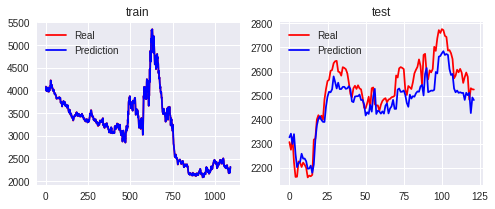

In [0]:
fig=plt.figure(figsize=(8,3))


plt.subplot(1,2,1)
plt.plot(sc_dict['close'].inverse_transform(y_train.values.reshape(-1,1)).reshape(-1),color='red',label='Real')
plt.plot(sc_dict['close'].inverse_transform(y_train_pred.reshape(-1,1)).reshape(-1),color='blue',label='Prediction')
plt.title('train')
plt.legend()
plt.subplot(1,2,2)
plt.plot(sc_dict['close'].inverse_transform(y_test.values.reshape(-1,1)).reshape(-1),color='red',label='Real')
plt.plot(sc_dict['close'].inverse_transform(y_pred.reshape(-1,1)).reshape(-1),color='blue',label='Prediction')
plt.title('test')
plt.legend()

plt.show()

In [0]:
list(OrderedDict(sorted(best_xgb_model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True)).items())[1:]

[('SP500_Volume', 2732),
 ('SP500_Open', 1803),
 ('SP500_Low', 1052),
 ('SP500_Close', 975),
 ('SP500_High', 932),
 ('CPI', 269),
 ('PPI_ppiip', 206),
 ('GDP Growth Rate', 197),
 ('PPI_clothing', 145),
 ('PPI_cg', 129),
 ('MS_m1_yoy', 127),
 ('PPI_dcg', 114),
 ('MS_m0_yoy', 110),
 ('PPI_pi', 96),
 ('PPI_food', 86),
 ('MS_rests', 81),
 ('PPI_roeu', 78),
 ('PPI_qm', 70),
 ('US_Stock_Earnings', 68),
 ('MS_m0', 62),
 ('US_Stock_E', 62),
 ('US_Stock_Rate GS10', 56),
 ('US_Stock_CPI', 55),
 ('MS_m2', 49),
 ('Sentiment - (1 for pos, -1 for neg)', 40),
 ('PPI_rmi', 37),
 ('MS_m2_yoy', 33),
 ('US_Stock_P', 28),
 ('MS_m1', 21),
 ('US_Stock_Price', 20),
 ('MS_ftd', 18),
 ('MS_cd', 17),
 ('MS_qm', 15),
 ('PPI_ppi', 14),
 ('US_Stock_CAPE', 12),
 ('MS_sd', 9)]

In [0]:
np.sqrt(mean_squared_error(sc_dict['close'].inverse_transform(y_test.values.reshape(-1,1)).reshape(-1),sc_dict['close'].inverse_transform(y_pred.reshape(-1,1)).reshape(-1)))

69.3902830781478

In [0]:
Y=df_scaled['close'].values

In [0]:
Y_up=[]
for i in range(len(Y)-1):
  if Y[i+1]>Y[i]:Y_up.append(1)
  else:Y_up.append(0)
  

In [0]:
X_train=df_scaled.iloc[0:-121-1]
y_up_train=Y_up[0:len(X_train)]
X_test=df_scaled.iloc[-122-1:-1]
y_up_test=Y_up[len(X_train):]

In [0]:
best_xgb_model_updown = xgboost.XGBRegressor(colsample_bytree=1,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=3,
                 min_child_weight=1,
                 n_estimators=10000,                                                                    
                 reg_alpha=1e-05,
                 reg_lambda=0.01,
                 subsample=0.95,
                 seed=1992)
best_xgb_model_updown.fit(X_train,y_up_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1e-05, reg_lambda=0.01, scale_pos_weight=1, seed=1992,
       silent=True, subsample=0.95)

In [0]:
list(OrderedDict(sorted(best_xgb_model.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True)).items())[1:]

[('change', 213),
 ('vol', 208),
 ('open', 191),
 ('SP500_Volume', 179),
 ('close', 164),
 ('pct_chg', 128),
 ('SP500_Open', 119),
 ('amount', 97),
 ('low', 94),
 ('SP500_High', 88),
 ('SP500_Close', 86),
 ('high', 81),
 ('SP500_Low', 74),
 ('CPI', 36),
 ('PPI_dcg', 33),
 ('PPI_clothing', 26),
 ('US_Stock_Earnings', 23),
 ('MS_m0_yoy', 22),
 ('PPI_pi', 20),
 ('MS_m2', 18),
 ('PPI_ppiip', 12),
 ('PPI_cg', 12),
 ('MS_m1_yoy', 12),
 ('MS_m0', 10),
 ('MS_rests', 10),
 ('PPI_food', 10),
 ('PPI_qm', 8),
 ('PPI_ppi', 8),
 ('GDP Growth Rate', 7),
 ('MS_m2_yoy', 6),
 ('PPI_rmi', 6),
 ('US_Stock_E', 5),
 ('US_Stock_Rate GS10', 4),
 ('MS_cd', 4),
 ('MS_ftd', 4),
 ('US_Stock_P', 4),
 ('PPI_roeu', 3),
 ('US_Stock_Price', 3),
 ('MS_m1', 2),
 ('diff', 2),
 ('US_Stock_CPI', 2),
 ('MS_sd', 1),
 ('Sentiment - (1 for pos, -1 for neg)', 1),
 ('US_Stock_CAPE', 1)]

In [0]:
y_pred_raw=best_xgb_model_updown.predict(X_test)

In [0]:
def mapupdown(val):
  if val>0.5:return 1
  else: return 0

In [0]:
y_up_pred=list(map(mapupdown,y_pred_raw))

In [0]:
correct=0
for pred,test in zip(y_up_pred,y_up_test):
  if pred==test:correct+=1
correct/len(y_pred)

0.5327868852459017